# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
![graphcut.png](attachment:graphcut.png)

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
import networkx as nx
from networkx.algorithms.flow import shortest_augmenting_path
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
#!/usr/bin/env python

import numpy as np
from sklearn.cluster import KMeans


class GaussianMixture:
    def __init__(self, X, n_components=5):
        
        self.n_components = n_components
        self.n_features = X.shape[1]
        self.n_samples = np.zeros(self.n_components)

        self.coefs = np.zeros(self.n_components)
        self.means = np.zeros((self.n_components, self.n_features))
        # Full covariance
        self.covariances = np.zeros(
            (self.n_components, self.n_features, self.n_features))

        self.init_with_kmeans(X)

    def init_with_kmeans(self, X):
        label = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
        self.fit(X, label)

    def calc_score(self, X, ci):
      
        score = np.zeros(X.shape[0])
        if self.coefs[ci] > 0:
            diff = X - self.means[ci]
            mult = np.einsum(
                'ij,ij->i', diff, np.dot(np.linalg.inv(self.covariances[ci]), diff.T).T)
            score = np.exp(-.5 * mult) / np.sqrt(2 * np.pi) / \
                np.sqrt(np.linalg.det(self.covariances[ci]))

        return score

    def calc_prob(self, X):
       
        prob = [self.calc_score(X, ci) for ci in range(self.n_components)]
        return np.dot(self.coefs, prob)

    def which_component(self, X):
        prob = np.array([self.calc_score(X, ci)
                         for ci in range(self.n_components)]).T
        # print(prob)
        return np.argmax(prob, axis=1)

    def fit(self, X, labels):
        assert self.n_features == X.shape[1]

        self.n_samples[:] = 0
        self.coefs[:] = 0

        uni_labels, count = np.unique(labels, return_counts=True)
        self.n_samples[uni_labels] = count

        variance = 0.01
        for ci in uni_labels:
            n = self.n_samples[ci]

            self.coefs[ci] = n / np.sum(self.n_samples)
            self.means[ci] = np.mean(X[ci == labels], axis=0)
            self.covariances[ci] = 0 if self.n_samples[ci] <= 1 else np.cov(
                X[ci == labels].T)

            det = np.linalg.det(self.covariances[ci])
            if det <= 0:
                # Adds the white noise to avoid singular covariance matrix.
                self.covariances[ci] += np.eye(self.n_features) * variance
                det = np.linalg.det(self.covariances[ci])



In [3]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [4]:
def run(filename: str,n_components=5,no_iteration=1):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img = cv2.resize(img,(0,0),fx=0.6,fy=0.6)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    final_mask = mask.copy()
    gc = None
    while(1):       
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            plt.figure(figsize=(12,12))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

            plt.show()
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
            FLAGS['rect_or_mask'] = 1
            
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
            FLAGS['rect_or_mask'] = 1
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            if EventObj.FLAGS['rect_or_mask'] == 0:
                gc = GraphCut()
                mask = gc.start(EventObj,n_components,no_iteration)
            else:
                mask = gc.interactiveSegmentation(img, mask)
            print('Segmentation done.')

#             print('done')

        EventObj.mask = mask          
        EventObj.flags = FLAGS
        mask2 = np.where(np.logical_or(mask == 2,mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)
      

In [ ]:
class GraphCut:
    def __init__(self):
        self.beta = None
        self.gamma = 25
        self.alpha = None
        self.fg_gmm = None
        self.bg_gmm = None
        
    def createGraph(self, img, alpha):
        graph = nx.Graph()
        bgpnl = -np.log(self.bg_gmm.calc_prob(img.reshape(-1,3)))
        bgpnl = bgpnl.reshape(alpha.shape)
        
        fgpnl = -np.log(self.fg_gmm.calc_prob(img.reshape(-1,3)))
        fgpnl = fgpnl.reshape(alpha.shape)
        
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                
                #add neighbour pixel edges
                ii = [-1,0,1,0]
                jj = [0,-1,0,1]
                for di,dj in zip(ii,jj):
                    adj_i = i + di
                    adj_j = j + dj
                    if adj_i >= 0 and adj_i < img.shape[0] and adj_j >= 0 and adj_j < img.shape[1]:
                        cap = self.gamma * np.exp(-self.beta*(np.sum(np.square(img[i][j] - img[adj_i][adj_j]))))
                        graph.add_edge((i,j),(adj_i,adj_j),capacity = cap)
                
                #add edges to sink and edges to terminal
                if alpha[i][j] == 0:
                    graph.add_edge('S',(i,j),capacity = 0)
                    graph.add_edge('T',(i,j))
                elif alpha[i][j] == 1:
                    graph.add_edge('T',(i,j),capacity = 0)
                    graph.add_edge('S',(i,j))
                else:
                    graph.add_edge('S',(i,j), capacity =  bgpnl[i][j])
                    graph.add_edge('T',(i,j), capacity = fgpnl[i][j])
               
                    
        return graph
                
    
    def start(self,EventObj,n_components,no_iteration):
        
        #initialisation step
        print('GMM no of components ',n_components)
        img = np.array(EventObj.img)
        alpha = np.zeros(img.shape[:2])
        x,y,xw,yw = EventObj.FLAGS['RECT'] 
        alpha[y:y+yw,x:x+xw] = 2
        fg_cord = np.where(alpha != 0)
        bg_cord = np.where(alpha == 0)  
        self.fg_gmm = GaussianMixture(img[fg_cord], n_components )
        self.bg_gmm = GaussianMixture(img[bg_cord], n_components )
        self.beta =  (2.0*np.sum(np.square(4*img[1:-1,1:-1] - img[0:-2,1:-1] - img[2:,1:-1] - img[1:-1,0:-2] - img[1:-1,2:])))/img[1:-1,1:-1].size
        self.beta = 1/self.beta
       
        for itr in range(no_iteration):
            #print('Iteration ',itr)
            
            fg_cord = np.where(alpha != 0)
            bg_cord = np.where(alpha == 0) 
            
            #print('fg bg',len(fg_cord[0]), len(bg_cord[0]))
            kn_fg_cord = self.fg_gmm.which_component(img[fg_cord])
            kn_bg_cord = self.bg_gmm.which_component(img[bg_cord])

            self.fg_gmm.fit(img[fg_cord],kn_fg_cord)
            self.bg_gmm.fit(img[bg_cord],kn_bg_cord)

            graph = self.createGraph(img, alpha)
#             print('Graph created')
            cut_value, partition = nx.minimum_cut(graph, 'S', 'T', flow_func=shortest_augmenting_path)
#             print('Partition created ',len(partition[0]),len(partition[1]))
            
            
            alpha.fill(0)
            for fg_node in partition[0]:                   
                if fg_node != 'S':
                    alpha[fg_node[0]][fg_node[1]] = 2
            

        return alpha
    
    def interactiveSegmentation(self, img, mask):
         print(len(np.where(mask!=0)[0]))
#          cv2.imshow('mask',mask)
#          cv2.waitKey(0)
#          print('Inside int seg')
         graph = self.createGraph(img, mask)
#          print('Graph created')
         cut_value, partition = nx.minimum_cut(graph, 'S', 'T', flow_func=shortest_augmenting_path)
#          print('Partition created ',len(partition[0]),len(partition[1]))
         
         mask.fill(0)
         for fg_node in partition[0]:                   
            if fg_node != 'S' and mask[fg_node[0]][fg_node[1]] != 1:
                mask[fg_node[0]][fg_node[1]] = 2
         return mask




In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Report
## No of Iterations
 As No of iterations increases segmentations gets better.


Iteration 1
Draw the rectangle first.
no_components  5
done


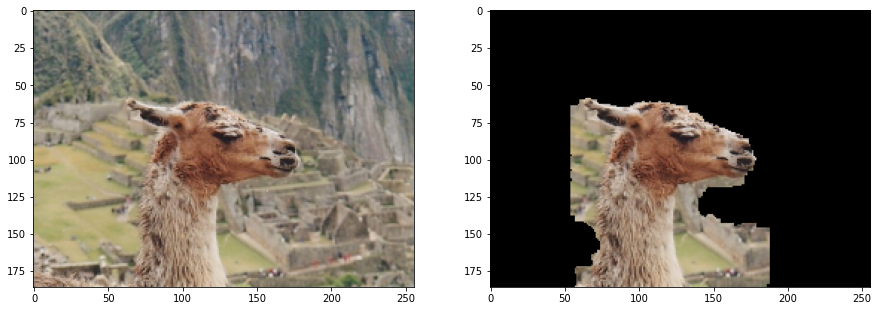

Iteration 2
Draw the rectangle first.
no_components  5
done


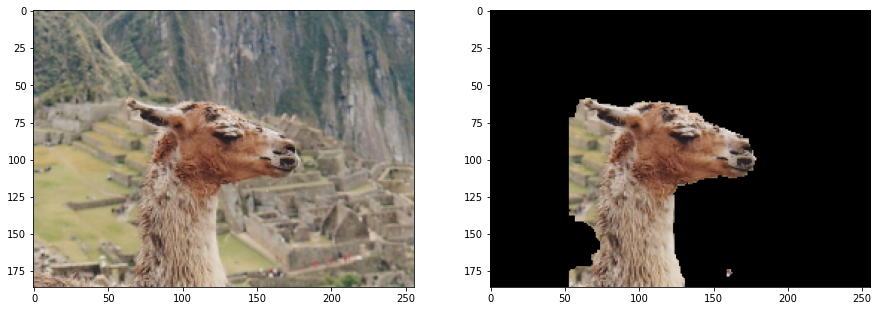

Iteration 3
Draw the rectangle first.
no_components  5
done


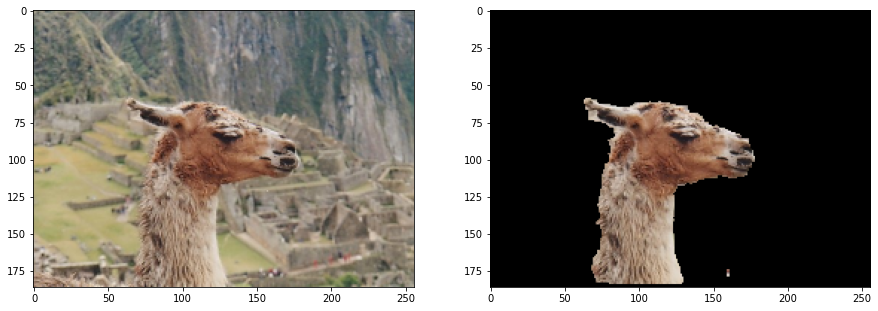

Iteration 4
Draw the rectangle first.
no_components  5


<ipython-input-80-d1d97bb9dc5b>:14: RuntimeWarning: divide by zero encountered in log
  fgpnl = -np.log(self.fg_gmm.calc_prob(img.reshape(-1,3)))


done
Draw the rectangle first.
no_components  5
done


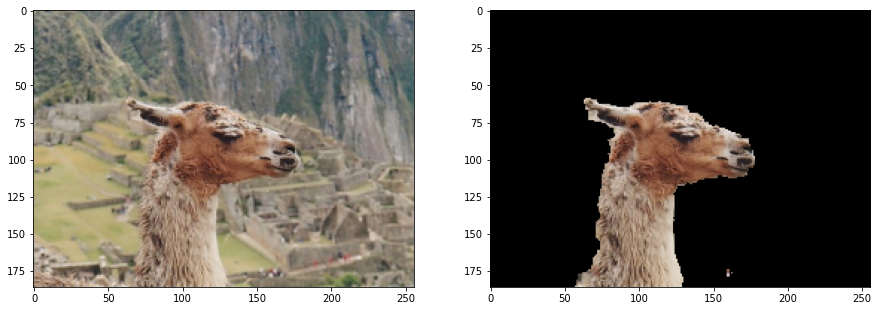

Iteration 5
Draw the rectangle first.
no_components  5


<ipython-input-80-d1d97bb9dc5b>:14: RuntimeWarning: divide by zero encountered in log
  fgpnl = -np.log(self.fg_gmm.calc_prob(img.reshape(-1,3)))


done


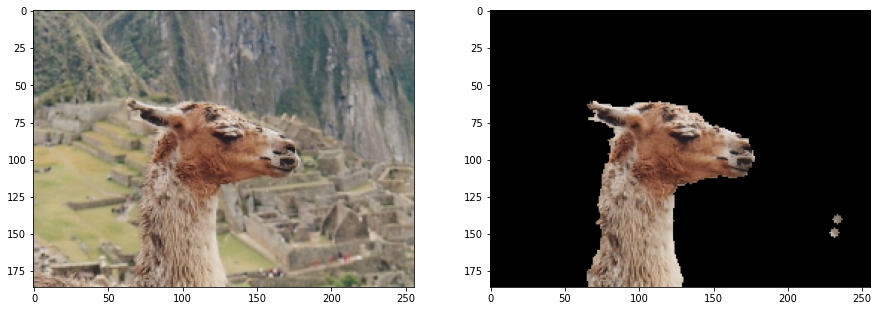

In [ ]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'  # Path to image file
    print('Iteration 1')
    run(filename,no_iteration = 1)
    print('Iteration 2')
    run(filename,no_iteration = 2)
    print('Iteration 3')
    run(filename,no_iteration = 3)
    print('Iteration 4')
    run(filename,no_iteration = 4)
    print('Iteration 5')
    run(filename,no_iteration = 5)
    cv2.destroyAllWindows()

# Gamma

Gamma = 25
Draw the rectangle first.
Segmentation done.


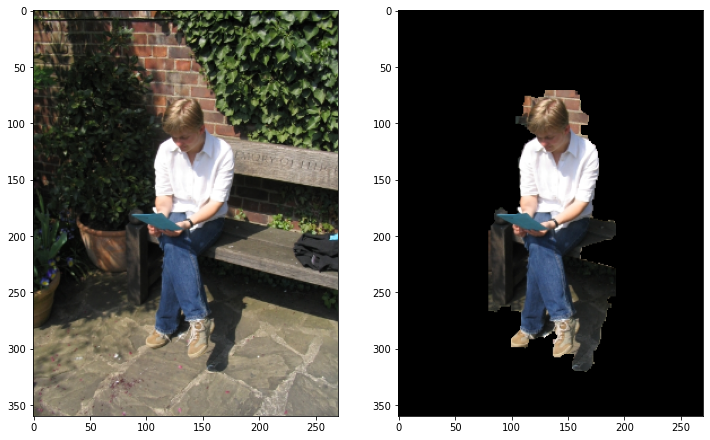

In [ ]:
print('Gamma = 25')
filename = '../images/person6.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

Gamma = 50
Draw the rectangle first.
Graph created
Partition created  14991 82211
Segmentation done.
14019
Inside int seg
Graph created
Partition created  13543 83659
Segmentation done.


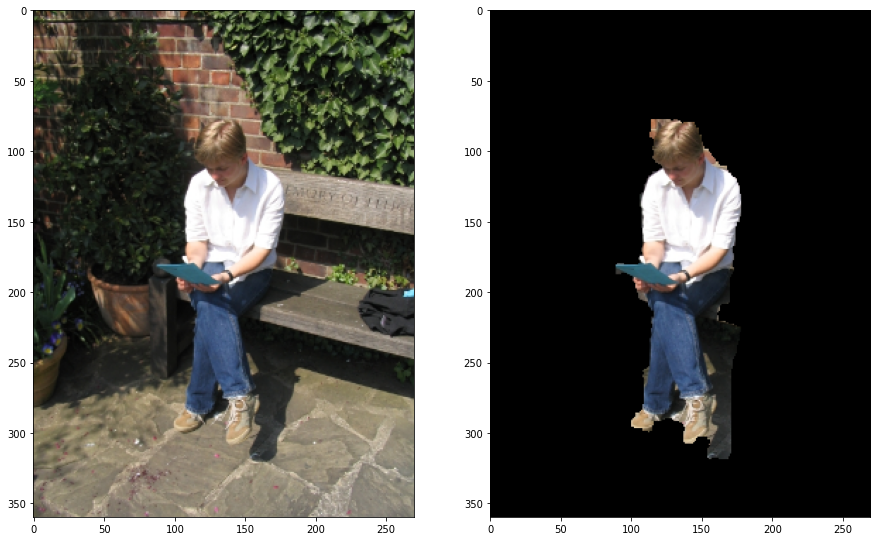

In [ ]:
print('Gamma = 50')
filename = '../images/person6.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

Gamma = 75
Draw the rectangle first.
Draw the rectangle first.
Segmentation done.


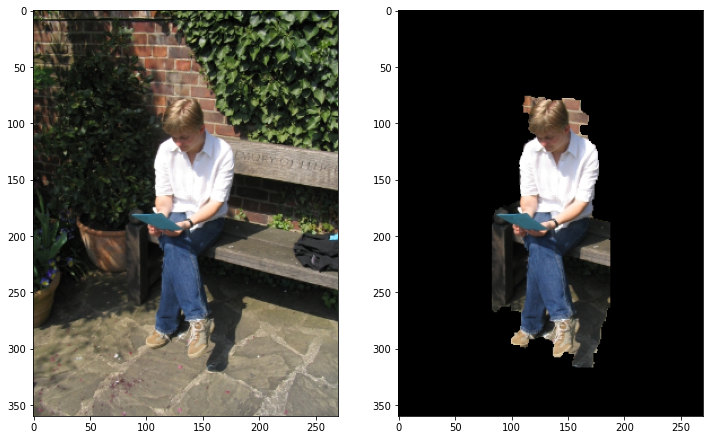

In [ ]:
print('Gamma = 75')
filename = '../images/person6.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

Gamma = 100
Draw the rectangle first.
Segmentation done.


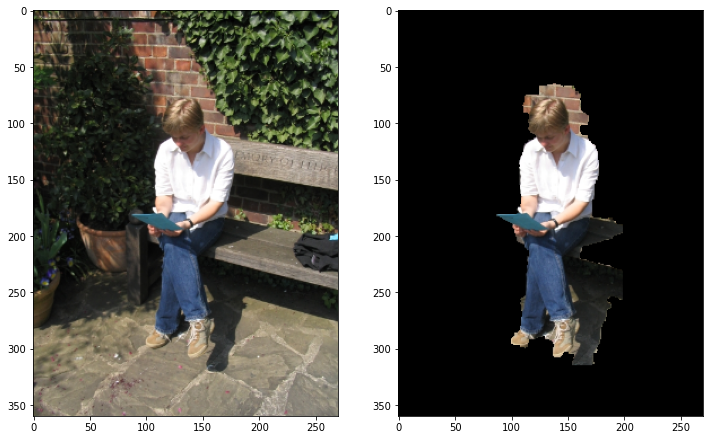

In [ ]:
print('Gamma = 100')
filename = '../images/person6.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

# No of Gmm Components

No of GMM components 3
Draw the rectangle first.
GMM no of components  3
Segmentation done.


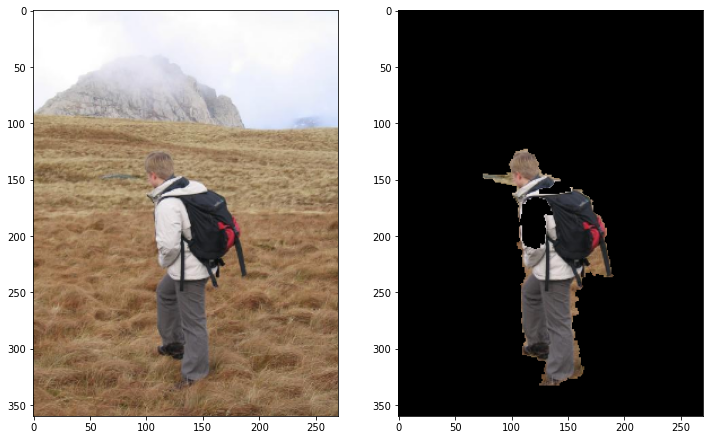

In [ ]:
print('No of GMM components 3')
filename = '../images/person3.jpg'  # Path to image file
run(filename,n_components = 3)
cv2.destroyAllWindows()

No of GMM components 5
Draw the rectangle first.
GMM no of components  5
Segmentation done.


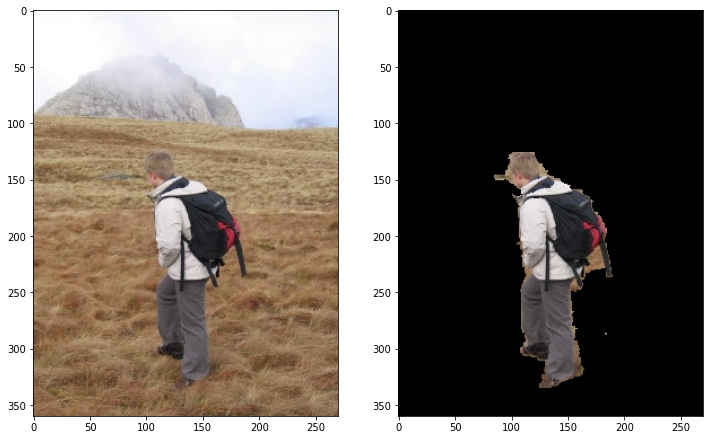

In [ ]:
print('No of GMM components 5')
filename = '../images/person3.jpg'  # Path to image file
run(filename,n_components = 5)
cv2.destroyAllWindows()

Draw the rectangle first.
GMM no of components  8
Segmentation done.


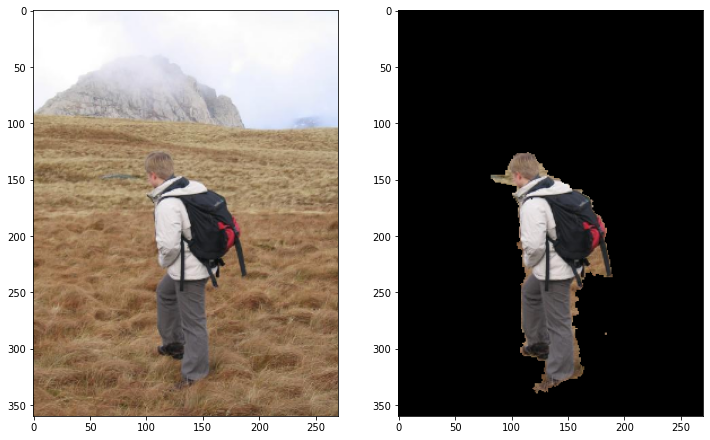

In [ ]:
filename = '../images/person3.jpg'  # Path to image file
run(filename,n_components = 8)
cv2.destroyAllWindows()

Draw the rectangle first.
GMM no of components  12
Segmentation done.


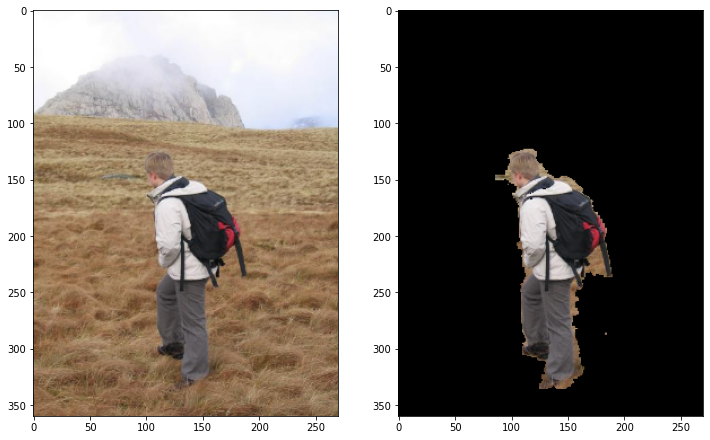

In [ ]:
filename = '../images/person3.jpg'  # Path to image file
run(filename,n_components = 12)
cv2.destroyAllWindows()

# Other Results

Draw the rectangle first.


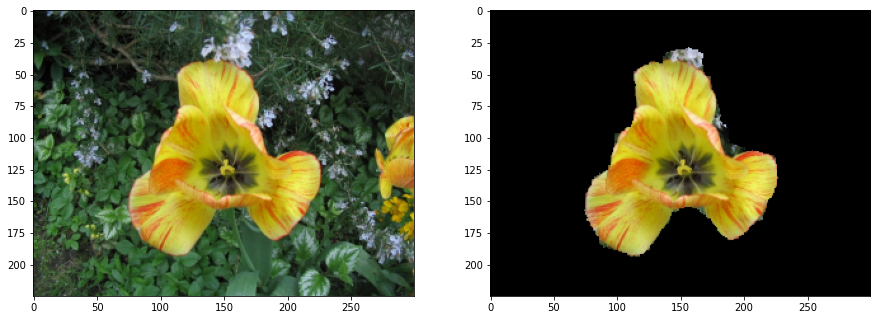

In [ ]:
filename = '../images/flower.jpg'  # Path to image file
run(filename)

Draw the rectangle first.
GMM no of components  5
Segmentation done.


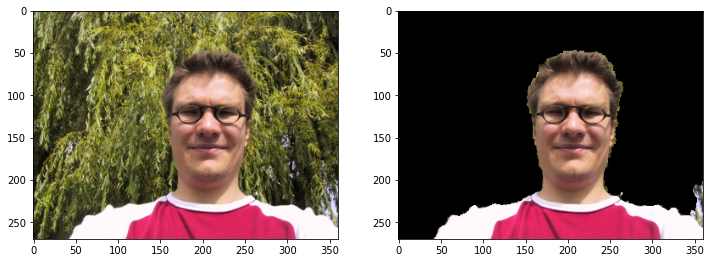

In [ ]:
filename = '../images/person1.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

Draw the rectangle first.
GMM no of components  5
Segmentation done.


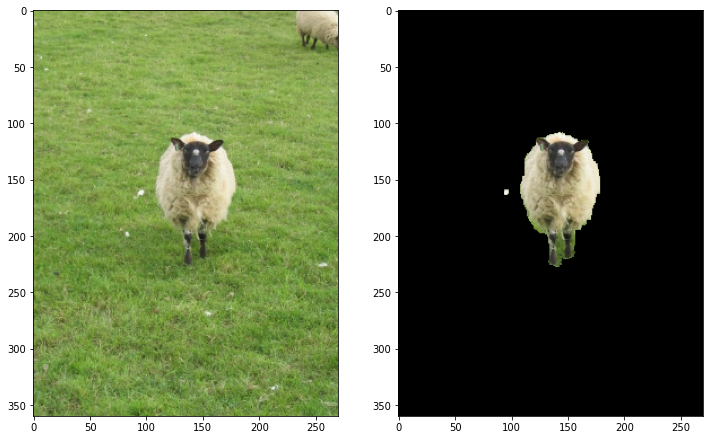

In [ ]:
filename = '../images/sheep.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()

In [ ]:
filename = '../images/stone2.jpg'  # Path to image file
run(filename)
cv2.destroyAllWindows()